In [38]:
import networkx as nx
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import matplotlib

In [39]:
G=nx.karate_club_graph()
A=nx.to_numpy_array(G, weight=None)
K=np.array(G.degree())[:,1]
m=np.sum(K)/2.0
B=A-np.outer(K,K.T)/(2.0*m)

In [40]:
def calculate_metrics_evolution(records):
    deg = nx.degree_centrality(records)
    betw = nx.betweenness_centrality(records)
    clos = nx.closeness_centrality(records)
    clust = nx.clustering(records)
    return {
        "degree": deg,
        "betweenness": betw,
        "closeness": clos,
        "clustering": clust
    }

In [41]:
def spectral_multicommunity_split(Graph, history=None, metrics_history=None):
    if history is None:
        history = []

    if metrics_history is None:
        metrics_history = []

    nodes = list(Graph.nodes)

    if len(nodes) <= 1:
        history.append([nodes])
        return history

    B_sub = B[np.ix_(nodes, nodes)]
    vals, vecs = eigh(B_sub)
    leading_vec = vecs[:, -1]
    s = np.where(leading_vec > 0, 1, -1)

    pos = [nodes[i] for i in range(len(nodes)) if s[i] == 1]
    neg = [nodes[i] for i in range(len(nodes)) if s[i] == -1]


    if vals[-1] < 0 or len(pos)==0 or len(neg)==0:
        history.append([nodes])
        return history


    history.append([pos, neg])

    metrics_for_step = {}

    metrics_for_step = {
        "pos": calculate_metrics_evolution(Graph.subgraph(pos)),
        "neg": calculate_metrics_evolution(Graph.subgraph(neg)),
    }

    metrics_history.append(metrics_for_step)

    spectral_multicommunity_split(Graph.subgraph(pos), history, metrics_history)
    spectral_multicommunity_split(Graph.subgraph(neg), history, metrics_history)

    return history, metrics_history

In [42]:
history, metric_history=spectral_multicommunity_split(G)

In [43]:
def community_plot(G, history):
    pos = nx.spring_layout(G, seed=42)
    current_communities = [list(G.nodes)]

    splits_only = [step for step in history if len(step) == 2 and len(step[0]) > 0 and len(step[1]) > 0]

    if not splits_only:
        print("No splits to visualize")
        return

    n_splits = len(splits_only)
    n_cols = 2  # Fixed to 2 columns
    n_rows = (n_splits + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5*n_rows))
    axes = np.atleast_1d(axes).flatten()

    cmap = matplotlib.colormaps.get("tab10", plt.get_cmap("tab10"))

    for depth, step in enumerate(splits_only):
        new_communities = []
        split_union = set(step[0]) | set(step[1])

        for community in current_communities:
            if set(community) == split_union:
                new_communities.extend([step[0], step[1]])
            else:
                new_communities.append(community)

        current_communities = new_communities

        node_colors = {node: cmap(ci % 10) for ci, comm in enumerate(current_communities) for node in comm}

        nx.draw_networkx(
            G,
            pos=pos,
            ax=axes[depth],
            with_labels=True,
            node_color=[node_colors[n] for n in G.nodes()],
            edge_color="gray",
            font_size=8,
            node_size=300
        )

        axes[depth].set_title(f"Split {depth+1} — {len(current_communities)} communities", fontsize=12)
        axes[depth].axis("off")

    for ax in axes[n_splits:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [44]:
def metrics_evolution_plot(metrics_history):
    metric_names = ["degree", "betweenness", "closeness", "clustering"]

    all_nodes = {
        node
        for step in metrics_history
        for side in ["pos", "neg"] if side in step
        for metric_dict in step[side].values()
        for node in metric_dict.keys()
    }

    for metric in metric_names:
        plt.figure(figsize=(10, 6))

        for node in sorted(all_nodes):
            splits = []
            values = []

            for step_idx, step in enumerate(metrics_history):
                val = next(
                    (step[side][metric].get(node)
                     for side in ["pos", "neg"]
                     if side in step and node in step[side][metric]),
                    None
                )
                if val is not None:  # Only plot non-None values
                    splits.append(step_idx)
                    values.append(val)

            if values:  # Only plot if node has any values
                plt.plot(splits, values, marker="o", label=f"Node {node}", alpha=0.5)

        plt.title(f"{metric.capitalize()} Over Splits", fontsize=16)
        plt.xlabel("Split Iteration", fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Zachary's Karate Club Graph 


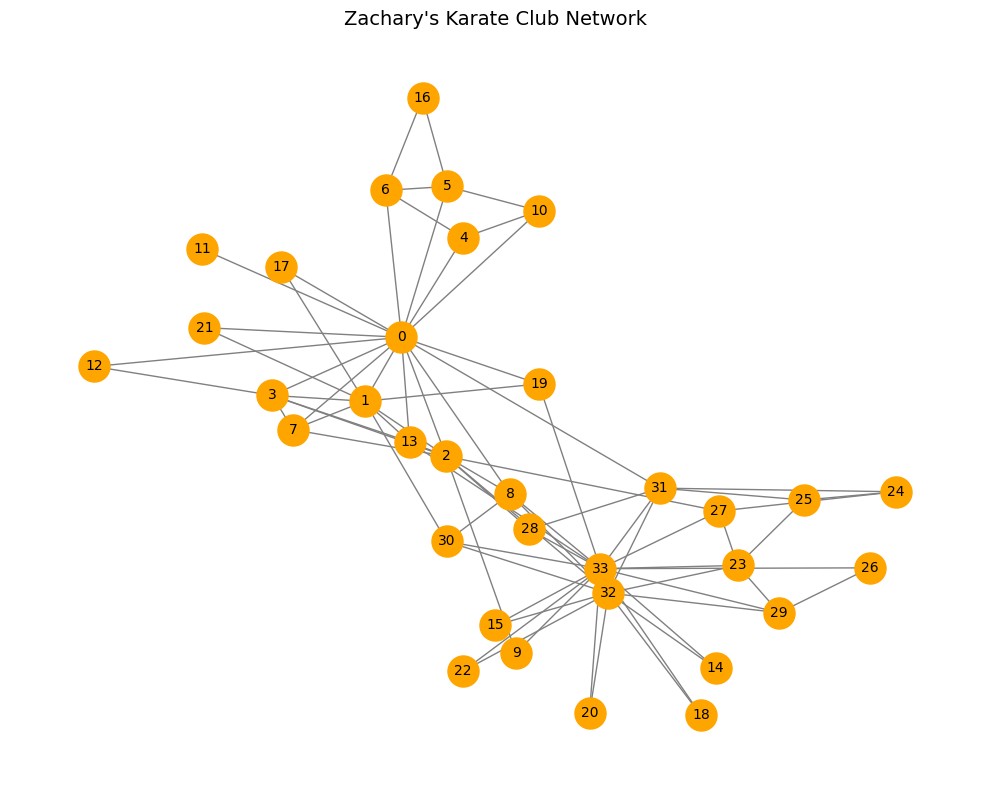

In [45]:
print("Zachary's Karate Club Graph","\n","="*200)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='orange',
                node_size=500, edge_color='gray', font_size=10)
plt.title("Zachary's Karate Club Network", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

Final Communities: 
community 1:  [24, 25, 27, 28, 31] 

community 2:  [32, 33, 8, 9, 14, 15, 18, 20, 22, 23, 26, 29, 30] 

community 3:  [0, 1, 2, 3, 7, 12, 13, 17, 19, 21] 

community 4:  [11] 

community 5:  [4, 5, 6, 10, 16] 



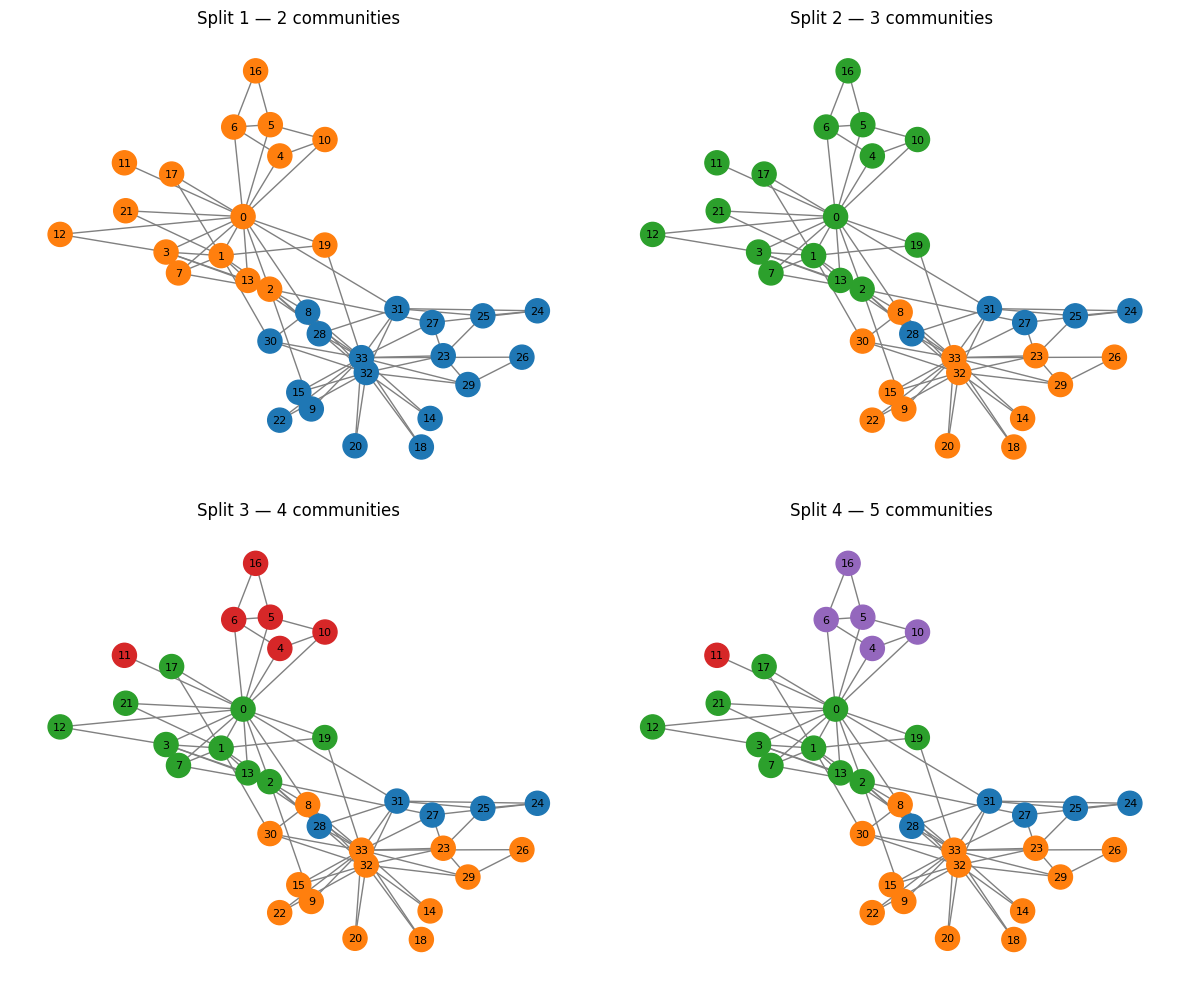

In [46]:
final_communities=[entry[0] for entry in history if len(entry) == 1]
print("Final Communities:","\n","="*200)
i=0
for communities in final_communities:
    print(f"community {i+1}: ", communities,"\n")
    i=i+1
print("="*200)
community_plot(G, history)

EVOLUTION OF METRICS OVER TIME 


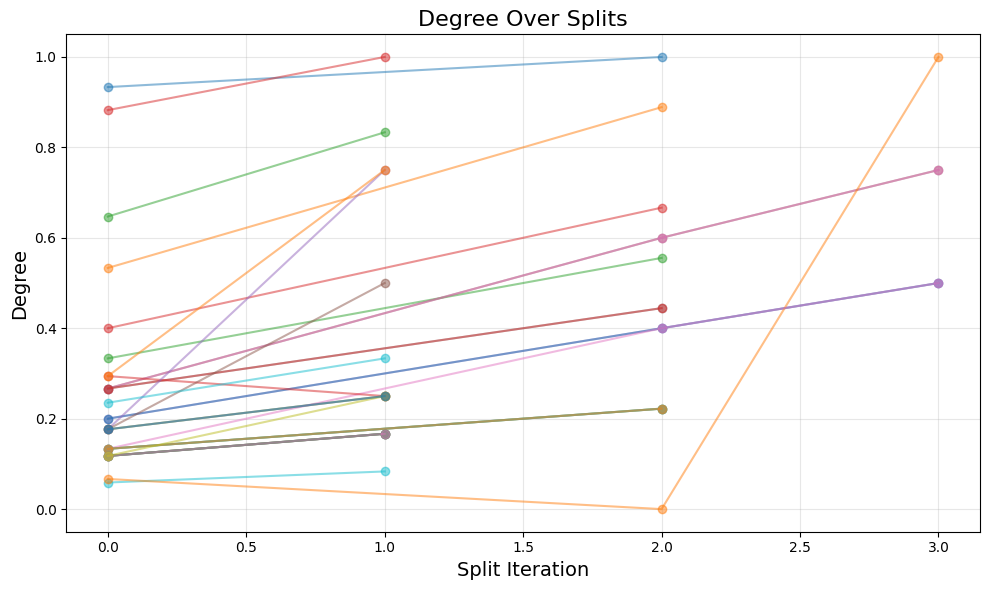

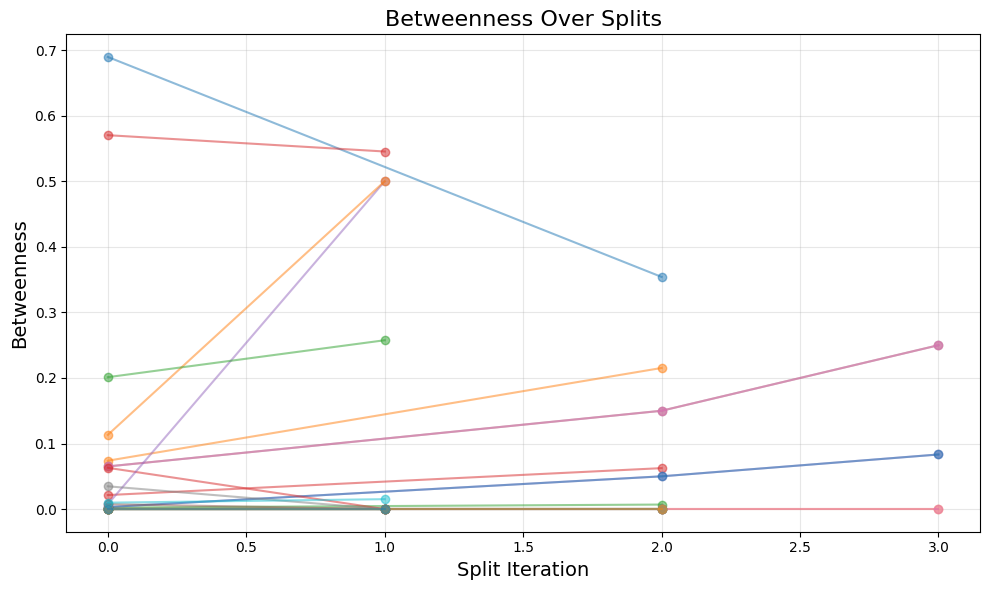

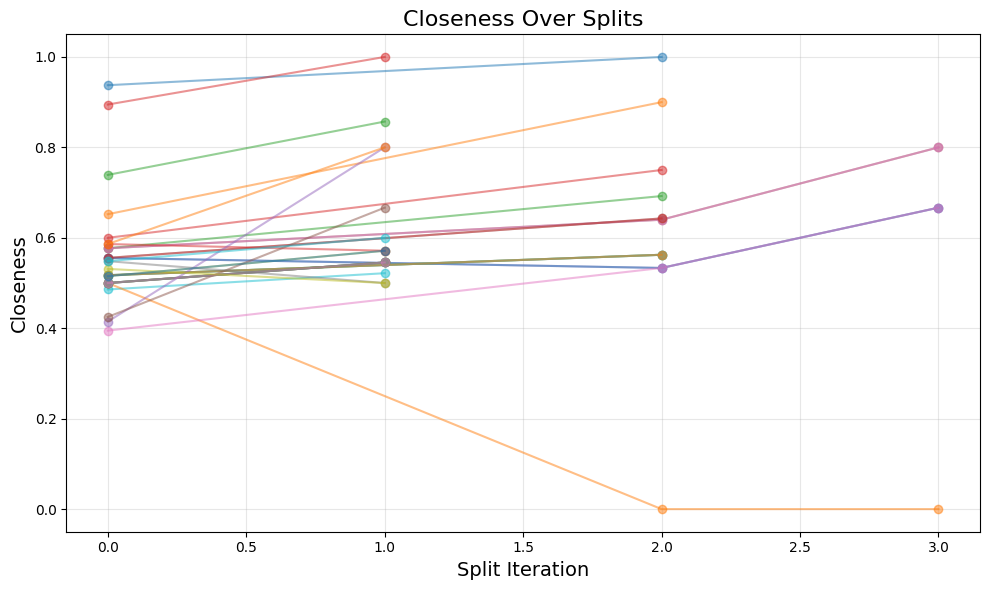

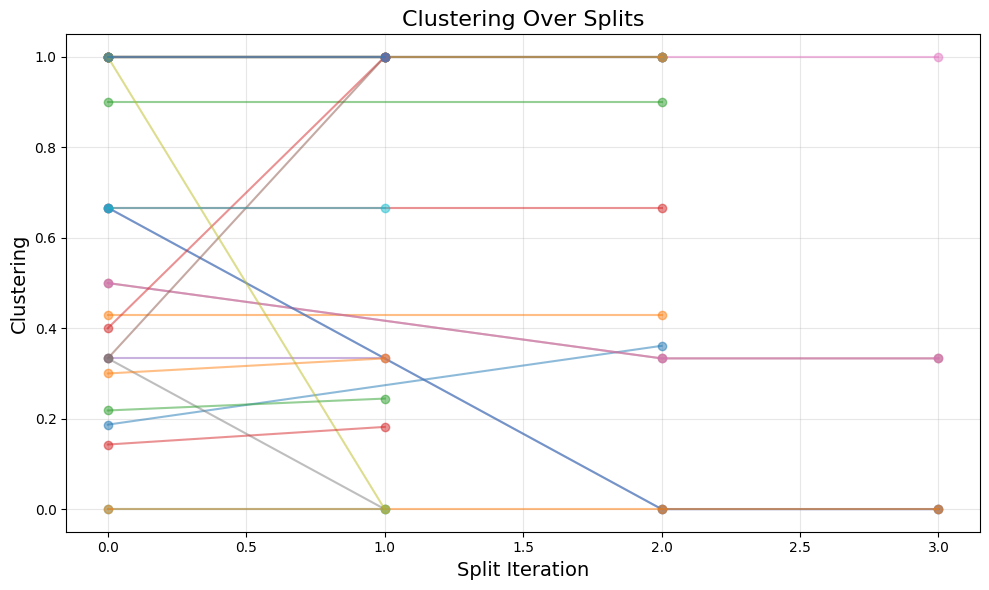

In [47]:
print("EVOLUTION OF METRICS OVER TIME","\n","="*200)
metrics_evolution_plot(metric_history)